In [1]:
%%capture

# For loading models, tokenizers, and datasets from HuggingFace
!pip -q uninstall pyarrow -y
!pip -q install pyarrow==15.0.2
!pip -q install datasets
!pip -q install accelerate
!pip -q install transformers

# For doing PEFT
!pip -q install --upgrade peft
!pip -q install --upgrade trl    # TRL - Transformer Reinforcement Learning; built on top of the 'transformers' library; Full stack library to fine-tune and align large language models
!pip -q install bitsandbytes     # for quantization
!pip install rouge_score==0.1.2


In [2]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM

from peft import LoraConfig, get_peft_model
from transformers import BitsAndBytesConfig
from transformers import TrainingArguments
from peft import LoraConfig, PeftModel, TaskType

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
f = open('hfapi_key.txt')
hfapi_key=f.read().strip()
os.environ["HF_TOKEN"] = hfapi_key
os.environ["HUGGINGFACEHUB_API_TOKEN"] = hfapi_key

In [4]:
from datasets import load_dataset
ds = load_dataset("big_patent", "g")

test_dataset= ds['test'].select(range(30))

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

In [53]:
ds

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 258935
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 14385
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 14386
    })
})

In [5]:
from datasets import concatenate_datasets, load_dataset
from datasets import load_dataset, concatenate_datasets, DatasetDict
train_dataset= ds['train'].select(range(10000))
val_dataset= ds['validation'].select(range(1000))

# Create a new DatasetDict
combined_dataset =DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})
combined_dataset


DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 1000
    })
})

import re

def remove_special_characters(example):
    example["description"] = re.sub(r"[^a-zA-Z0-9 ]", "", example["description"])  # Keep only alphanumeric characters and spaces
    return example
Train_data = Train_data.map(remove_special_characters)
validation_data = validation_data.map(remove_special_characters)
test_data = test_data.map(remove_special_characters)


In [5]:
import pandas as pd
ds = pd.DataFrame()

In [18]:
model_name = "google/pegasus-xsum"
tokenizer = AutoTokenizer.from_pretrained(model_name)

from transformers import BitsAndBytesConfig

# Load the model without quantization and device_map="auto" first
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,                            # Activate 4-bit precision base model loading
    bnb_4bit_quant_type="nf4",                    # Quantization type (fp4 or nf4)    nf4 -> Normal Float 4
    bnb_4bit_compute_dtype=torch.float16,         # Compute dtype for 4-bit base models
    bnb_4bit_use_double_quant=True,              # Whether to activate nested quantization for 4-bit base models (double quantization)
)

#model = AutoModelForSeq2SeqLM.from_pretrained(model_name,quantization_config=quantization_config)
#model = AutoModelForSeq2SeqLM.from_pretrained(model_name)




# Apply 4-bit quantization after loading
#from peft.utils import prepare_model_for_kbit_training
#model = prepare_model_for_kbit_training(model)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer
text= test_dataset['description'][0]
input_text=f"summarize following text:{text} in 500 words"
input_ids = tokenizer(input_text,truncation=True,padding='longest',return_tensors='pt')
summary_ids = model.generate(input_ids["input_ids"],max_length=128,min_length=20,num_beams=4)
summary = tokenizer.decode(summary_ids[0],skip_special_tokens=True)
print(summary)



A description of the invention can be found on the website of the United States Patent and Trademark Office at www.uspto.gov.


In [11]:

def preprocess_function(batch):
    inputs = tokenizer(batch["description"], max_length=512, truncation=True, padding='max_length')
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["abstract"], max_length=128, truncation=True, padding='max_length')
    inputs["labels"] = labels["input_ids"]
    return inputs

def preprocess_function(examples):
    inputs = examples["description"]
    targets = examples["abstract"]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding='max_length') # Add padding='max_length' here
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding='max_length') # Add padding='max_length' here
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [12]:

tokenized_datasets = combined_dataset.map(preprocess_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['description', 'abstract', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [13]:
train_dataset= tokenized_datasets['train']
val_dataset= tokenized_datasets['validation']

In [36]:
val_dataset

Dataset({
    features: ['description', 'abstract', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 500
})

In [14]:
from transformers import DataCollatorForSeq2Seq

In [15]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model,padding="longest")

In [19]:
# Create LoRA configuration object with LoRA-specific parameters
peft_config = LoraConfig(
   task_type=TaskType.SEQ_2_SEQ_LM,                 # telling lora that this is a causal language modeling task
   r=8,                      # 8, 16, 32  # LoRA attention dimension; the rank of the update matrices
   lora_alpha=32,                         # LoRA scaling factor
   lora_dropout=0.1,                      # Dropout probability for LoRA layers
   inference_mode = False,
   target_modules=['k_proj','v_proj','q_proj','fc1','fc2','lm_head']            # layers/blocks present in gemma-2b model
)

from peft import get_peft_model
# Number of trainable parameters
model = get_peft_model(model, peft_config=peft_config)


In [23]:
from transformers import Seq2SeqTrainingArguments,Seq2SeqTrainer

training_arguments = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,              # Reduced batch size
    gradient_accumulation_steps=4,              # Reduced gradient accumulation steps
    num_train_epochs=10,
    weight_decay=0.001,
    fp16=False,                                  # Enabled fp16 for lower memory usage
    optim="adamw_torch",
    save_strategy = "epoch",
    logging_steps=25,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    load_best_model_at_end=True,
)

In [24]:
from transformers import EarlyStoppingCallback, TrainingArguments, IntervalStrategy,Seq2SeqTrainer
import os

# Add this line to set CUDA_LAUNCH_BLOCKING before initializing the trainer
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

trainer = Seq2SeqTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop after 3 evaluations with no improvement
    tokenizer=tokenizer,
    data_collator=data_collator,
    #packing=True,                             # Pack multiple short examples in the same input sequence to increase efficiency
)


In [25]:
import os

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.491400,2.313865
2,2.277100,2.179539
3,2.188500,2.152997
4,2.311300,2.137878
5,2.322600,2.126853
6,2.181000,2.119152
7,2.171200,2.112862
8,2.097100,2.106981
9,2.103100,2.106684
10,2.204100,2.100643


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

TrainOutput(global_step=12500, training_loss=2.3763243524169924, metrics={'train_runtime': 28074.8523, 'train_samples_per_second': 3.562, 'train_steps_per_second': 0.445, 'total_flos': 1.462420021248e+17, 'train_loss': 2.3763243524169924, 'epoch': 10.0})

In [43]:
train_logs = trainer.state.log_history
training_loss = [log['loss'] for log in train_logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]
epochs = range(1, len(training_loss) + 1)

ValueError: x and y must have same first dimension, but have shapes (150,) and (3,)

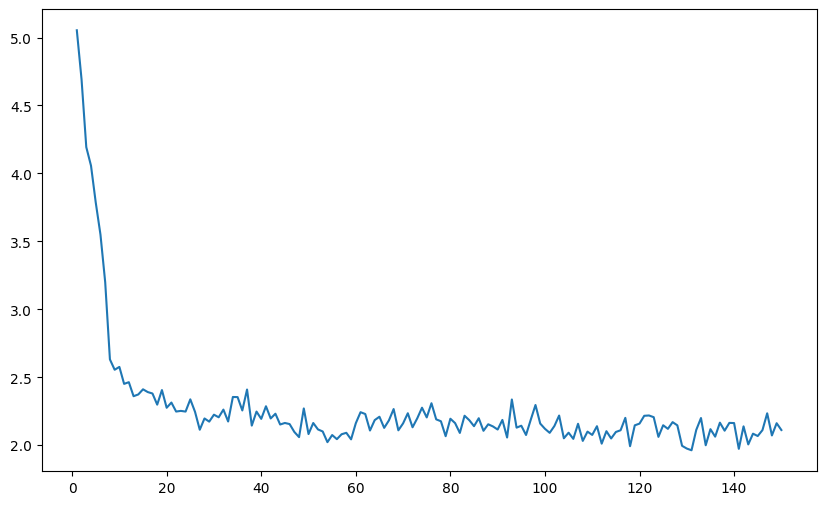

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.show()

In [26]:
# Save model
new_model = "pegasus-finetuned_10000"
trainer.model.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)

('pegasus-finetuned_10000/tokenizer_config.json',
 'pegasus-finetuned_10000/special_tokens_map.json',
 'pegasus-finetuned_10000/tokenizer.json')

In [6]:
new_model = AutoModelForSeq2SeqLM.from_pretrained('/teamspace/studios/this_studio/pegasus-finetuned_5000')
new_tokenizer = AutoTokenizer.from_pretrained('/teamspace/studios/this_studio/pegasus-finetuned_5000')

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


In [21]:
test_dataset['description'][0]

'REFERENCE TO RELATED APPLICATIONS  \n       [0001]     This application claims benefit of Application Ser. No. 60/481,847, filed Dec. 31, 2003, and of Application Ser. No. 60/561,754, filed Apr. 13, 2004.  \n         [0002]     The entire contents of the aforementioned applications are herein incorporated by reference. The entire contents of all United States Patents and published and copending Applications mentioned below are also herein incorporated by reference. \n     \n    \n     BACKGROUND OF THE INVENTION  \n       [0003]     This invention relates to electro-optic displays and to methods for driving such displays. More specifically, in one aspect this invention relates to electro-optic displays with simplified backplanes, and methods for driving such displays. In another aspect, this invention relates to electro-optic displays in which multiple types of electro-optic units are used to improve the colors available from the displays. The present invention is especially, though n

In [8]:
text= test_dataset['description'][0]
input_text=f"summarize following text:{text} in 500 words"
inputs = new_tokenizer(input_text, max_length=512, truncation=True, padding='max_length',return_tensors='pt')
summary_ids = new_model.generate(inputs["input_ids"],max_length=128,min_length=20,num_beams=4)
summary = new_tokenizer.decode(summary_ids[0],skip_special_tokens=True)
print(summary)


The present invention relates to electro-optic displays and to methods for driving such displays. More specifically, in one aspect this invention relates to electro-optic displays with simplified backplanes, and methods for driving such displays. In another aspect, this invention relates to electro-optic displays in which multiple types of electro-optic units are used to improve the colors available from the displays. The present invention is especially, though not exclusively, intended for use in electrophoretic displays.


In [51]:
text= test_dataset['description'][0]
input_text= f"""analyze the following text and provide point to point answer on following topic:
1. Concise summary
2. key inventions
3. potential commercial applications
Patent text: {text}"""
inputs = new_tokenizer(input_text, max_length=512, truncation=True, padding='max_length',return_tensors='pt')
summary_ids = new_model.generate(inputs["input_ids"],max_length=128,min_length=20,num_beams=4)
summary = new_tokenizer.decode(summary_ids[0],skip_special_tokens=True)
print(summary)

The present invention relates to electro-optic displays and to methods for driving such displays. More specifically, in one aspect this invention relates to electro-optic displays with simplified backplanes, and methods for driving such displays. In another aspect, this invention relates to electro-optic displays in which multiple types of electro-optic units are used to improve the colors available from the displays. The present invention is especially, though not exclusively, intended for use in electrophoretic displays.


In [55]:
test_dataset['abstract'][0]

'Electro-optic media are disclosed containing a plurality of types of electro-optic media within a single layer. The media provide blinking displays, displays in which images appear transiently and displays having a wider color gamut than conventional electro-optic displays'

In [24]:
test_dataset['abstract'][0]

'Electro-optic media are disclosed containing a plurality of types of electro-optic media within a single layer. The media provide blinking displays, displays in which images appear transiently and displays having a wider color gamut than conventional electro-optic displays'

***Model Evaluation***

In [7]:
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer

In [8]:
import torch
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig # Import GenerationConfig

def preprocess_function(examples):
    inputs = new_tokenizer(examples["description"], max_length=512, truncation=True, padding='max_length',return_tensors='pt')
    labels = new_tokenizer(examples["abstract"], max_length=128, truncation=True, padding='max_length',return_tensors='pt')
    inputs["labels"] = labels["input_ids"]
    return inputs

def generate_predictions(batch):
    # Convert list of lists to list of tensors before stacking
    input_ids = [torch.tensor(ids) for ids in batch["input_ids"]]
    inputs = torch.stack(input_ids).to(new_model.device)  # Move inputs to the same device as the model
    # Create a GenerationConfig object with the desired parameters
    generation_config = GenerationConfig(max_length=128, num_beams=4, early_stopping=True)
    # Pass the GenerationConfig object as part of the input_ids argument
    outputs = new_model.generate(input_ids=inputs, generation_config=generation_config)  # Pass inputs and generation_config as keyword arguments
    batch["predicted_summary"] = new_tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

test_dataset_token = test_dataset.map(preprocess_function, batched=True)
test_result = test_dataset_token.map(generate_predictions, batched=True)

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

In [9]:
import torch
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig # Import GenerationConfig

def preprocess_function(examples):
    inputs = tokenizer(examples["description"], max_length=512, truncation=True, padding='max_length',return_tensors='pt')
    labels = tokenizer(examples["abstract"], max_length=128, truncation=True, padding='max_length',return_tensors='pt')
    inputs["labels"] = labels["input_ids"]
    return inputs

def generate_predictions(batch):
    # Convert list of lists to list of tensors before stacking
    input_ids = [torch.tensor(ids) for ids in batch["input_ids"]]
    inputs = torch.stack(input_ids).to(model.device)  # Move inputs to the same device as the model
    # Create a GenerationConfig object with the desired parameters
    generation_config = GenerationConfig(max_length=128, num_beams=4, early_stopping=True)
    # Pass the GenerationConfig object as part of the input_ids argument
    outputs = model.generate(input_ids=inputs, generation_config=generation_config)  # Pass inputs and generation_config as keyword arguments
    batch["predicted_summary"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

test_dataset_token = test_dataset.map(preprocess_function, batched=True)
test_result = test_dataset_token.map(generate_predictions, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [10]:
!pip install evaluate
from evaluate import load

# Replace the original import with the following:
#from datasets import load_metric
rouge = load("rouge")

# The rest of the code remains unchanged.
results = rouge.compute(
    predictions=test_result["predicted_summary"],
    references=test_result["abstract"],
    use_aggregator=True,
    use_stemmer=True,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
!pip install bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
from bert_score import score

In [14]:
precision = []
recall = []
F1_score = []
for i in range(len(test_result["predicted_summary"])):
  P, R, F1 = score([test_result["predicted_summary"][i]], [test_result["abstract"][i]], lang="en", verbose=True)
  precision.append(P)
  recall.append(R) 
  F1_score.append(F1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.08 seconds, 0.24 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.64 seconds, 1.57 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.55 seconds, 1.82 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.62 seconds, 1.60 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.54 seconds, 1.85 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.96 seconds, 1.04 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.73 seconds, 1.36 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.98 seconds, 1.02 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.78 seconds, 1.27 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.30 seconds, 0.77 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.84 seconds, 1.18 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.63 seconds, 1.60 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.52 seconds, 1.94 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.49 seconds, 2.02 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.59 seconds, 1.69 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.72 seconds, 1.40 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.39 seconds, 2.58 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.68 seconds, 1.48 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.79 seconds, 1.26 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.69 seconds, 1.46 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.24 seconds, 0.81 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.83 seconds, 1.21 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 3.80 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.55 seconds, 1.81 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.45 seconds, 2.24 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.88 seconds, 1.14 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.00 seconds, 1.00 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.75 seconds, 1.33 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.42 seconds, 2.38 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.74 seconds, 1.36 sentences/sec


In [16]:
import numpy as np
print(f"Average precision of 10 samples:{np.array(precision).mean()}")
print(f"Average recall of 10 samples:{np.array(recall).mean()}")
print(f"Average F1 score of 10 samples:{np.array(F1_score).mean()}")

Average precision of 10 samples:0.8749162554740906
Average recall of 10 samples:0.8615079522132874
Average F1 score of 10 samples:0.8679551482200623


In [17]:
np.array(recall).mean()

0.8636092

In [18]:

np.array(F1_score).mean()

0.86524934